[MIT License](https://github.com/cdslaborg/paramonte#license)  
[ParaMonte: plain powerful parallel Monte Carlo library](https://github.com/cdslaborg/paramonte).  
Copyright (C) 2012-present, [The Computational Data Science Lab](https://www.cdslab.org/#about)  
https://github.com/cdslaborg/paramonte  
[References](https://www.cdslab.org/paramonte/notes/overview/preface/#how-to-acknowledge-the-use-of-the-paramonte-library-in-your-work)  

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%matplotlib notebook
import paramonte as pm
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
sns.set()

paramonte 2.3.0
numpy 1.19.2
scipy 1.5.2
pandas 1.1.3
seaborn 0.11.0
matplotlib 3.3.2


## Modeling the distribution of 1-dimensional data subject to sample incompleteness  

Supposed we have observed a dataset comprised of $15027$ events with one attribute variable in this [data.csv](https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_lognormal_data_paradram/data.csv) file. Plotting these points would yield a red-colored histogram like the following figure,  
  
<br><img src="https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_lognormal_data_paradram/data.png" width="60%"/><br>
  
The pale black shaded area represents the missing points from our observational dataset. These are points that we could NOT observe (or detect) because of some instrumental bias and sample incompleteness as represented by the black line.

**Statement of problem**  

Now, our goal is to form a hypothesis about this dataset, that is, a hypothesis about the distribution of the events in the above plot. To make a correct assessment, we will have to also carefully consider the effects of the detection threshold (the black line) in our inference.

The first thing we can do is to obtain a better visualization of this dataset. The data looks highly skewed to the right. Therefore, it makes sense to take the logarithm of this dataset in the hope that it can help us better understand the possible underlying generating distribution of this data,  
  
<br><img src="https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_lognormal_data_paradram/logdata.png" width="60%"/><br>

Just by looking at the observed (red) distribution, we can form a relatively good hypothesis about the distribution of the data: If the detection threshold did not exist, the complete dataset (including the points in the black shaded area) would likely very well resemble a lognormal distribution (or a normal distribution on the logarithmic axes).  

However, this dataset is affected by the detection threshold and we need to also take a model of the detection threshold into account. The logarithmic transformation makes it crystal-clear to us that the detection threshold is likely best modeled by as single value represented by the vertical line.  

Therefore, we form the following hypothesis,  

**Hypothesis**: Our data comes from a Lognormal distribution subject to censorship by sharp hard cutoff threshold. The proposition that data is lognormally distributed is mathematically equivalent to the proposition that `log(data)` is normally distributed.  

**Goal**: To **estimate the unknown parameters** of the Normal distribution, the **mean** and the **standard deviation**: ($\mu, \sigma$), as well as the **location of the sharp censorship threshold** in our data set ($\eta$).  

**Methodology**: We will use the maximum likelihood approach and the **ParaDRAM** (**Delayed-Rejection Adaptive Metropolis-Hastings Markov Chain Monte Carlo**) sampler of the `paramonte` library to estimate the 3 unknown parameters of our hypothesis.  

## Step 1: Read the data and log-transform it  

First read the data using Pandas library, then log-transform data to make it look like a Normal distribution.

In [3]:
url = "https://github.com/cdslaborg/paramontex/raw/main/Python/Jupyter/regression_censored_lognormal_data_paradram/data.csv"
df = pd.read_csv(url, header = None)
df.describe()

,0
count,15027.000000
mean,0.824782
std,0.498326
min,0.019044
25%,0.413535
50%,0.725890
75%,1.177000
max,1.999700


<IPython.core.display.Javascript object>


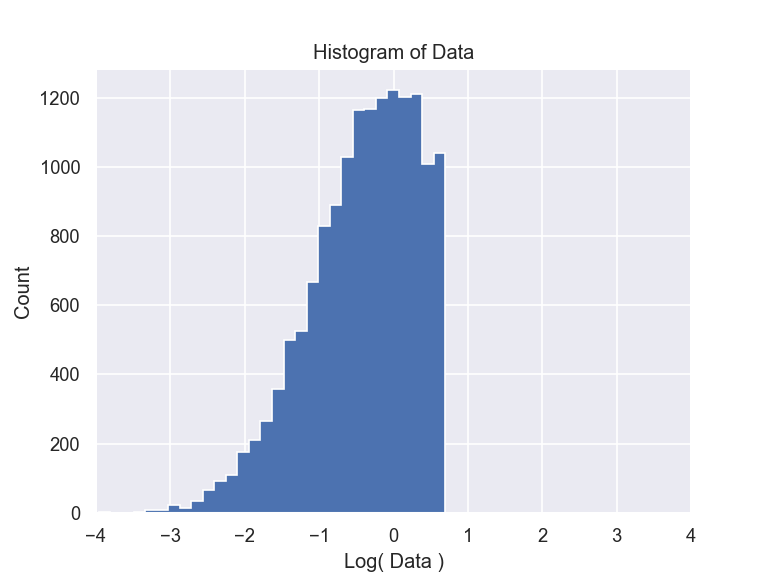

In [4]:
# log-transform data so that it can be fit by a Normal distribution

logdata = np.double(np.log(df.iloc[:,0]))

# plot histogram of log(data)

sns.set()
fig = plt.figure()
ax = fig.gca()
(n, bins, patches) = ax.hist(logdata, histtype='stepfilled', bins = 30)
plt.xlabel('Log( Data )')
plt.ylabel('Count')
plt.title('Histogram of Data')
ax.set_xlim([-4,4])
plt.grid(True)
plt.show()

## Step 2: Compute the probability of observing each data point under the hypothesis  

We will write a class that takes the `logdata` as input and has two methods, `getLogProb(x,avg,std,cutoff)` and `getLogLike(param)`. The former computes the log-probability of observing the input dataset data given a set of parameters for the model (the average `avg` and the standard deviation `std` of the Normal distribution, and the sharp cut on the distribution `cutoff`). The latter method `getLogLike(param)` must take the set of the parameters of our censored model as a vector. **We want to explore the shape of this 3-dimensional likelihood function** to find its mode and its width along the three axes, each of which represents one parameter of our model.  

Here is the mathematical equation of Normal Probability Density Function (PDF),  

$$
\large
\pi (x ~|~ \mu, \sigma) = \frac{1}{ \sigma~\sqrt{2\pi} } ~
\exp
\bigg( 
-\frac{(x-\mu)^2}{2\sigma^2} 
\bigg)
$$

However, our problem is more complicated than the above equation. The above equation gives the probability of obtaining a specific observation $x$ from a *full Normal* distribution, whereas the Normal distribution in our problem is heavily censored on its right tail. We must therefore take this censorship into account by renormalizing the above equation such that the integral of the censored PDF becomes unity again just as is the case for the above equation.  

For any given cutoff ($\eta$), the intergal of the above PDF in the range $[-\infty, \eta]$ can be expressed in terms of an **error function** ($\mathrm{erf}$),  

$$
\large
\int^{\eta}_{-\infty} \mathcal{N}(x ~|~ \mu, \sigma) ~ dx = \frac{1}{2} \bigg[ 1 + \mathrm{erf} \bigg( \frac{\eta-\mu}{\sigma\sqrt{2}} \bigg) \bigg] ~,
$$

Therefore, 
$$
\large
\pi (x ~|~ \mu, \sigma, \eta) = 
\begin{cases}
    \frac{1}{ \sigma~\sqrt{2\pi} } ~
    \exp
    \bigg( 
    -\frac{(x-\mu)^2}{2\sigma^2} 
    \bigg) ~
    \times ~
    \frac{2}{1 + \mathrm{erf} \bigg( \frac{\eta-\mu}{\sigma\sqrt{2}} \bigg)} ~~~,~~~ \forall ~ x~<~\eta \\
    0 ~~~,~~~ \forall ~ x~>=~\eta
\end{cases}
$$  
  
We will implement the logarithm of the above equation in `getLogProb()`.  

## Step 3: Compute the likelihood of data for a given set of parameters  

Now, with an equation at hand to compute the probabilities of individual data points for a given set of model parameters, we can go on to write the likelihood function of observing the entire dataset of $N$ observations for a given set of input parameters,  

$$
\large
\mathcal{L}\big( \{x_1, \ldots, ..., x_N \} ~;~ \mu, \sigma, \eta \big) = 
\prod^{N}_{i = 1} \pi (x ~|~ \mu, \sigma, \eta)
$$  

We can now implement the above likelihood function to find the most likely set of parameters for our hypothesis.  

---  

> Since the mathematical objective functions (e.g., probability density functions and likelihood functions) can take extremely small or large values, we often work with their natural logarithms instead. **This is the reason behind the naming convention used in the ParaMonte library for** the user's objective functions: **getLogFunc**, implying that **the user must provide a function that returns the natural logarithm of the target objective function**.  
  
  
See [this Jupyter Notebook](https://nbviewer.jupyter.org/github/cdslaborg/paramontex/blob/main/Python/Jupyter/working_with_logarithm_of_objective_function/working_with_logarithm_of_objective_function.ipynb) for an in-depth discussion of why we need to work with the logarithm of mathematical objective functions in optimization and sampling problems.  

---  

**Tip**  

+ What is the possible range of the mean (`avg`) of Normal distribution? $[-\infty, +\infty]$  
+ What is the possible range of the `cutoff` parameter?  $[-\infty, +\infty]$, although practically, its lower limit cannot be less than the maximum value of the our dataset.  
+ What is the possible range of the standard deviation (`std`) of the Normal distribution? By definition, $[0, +\infty]$  

Now, compare the range of `avg` and `cutoff` with `std` in the above. Did you notice the asymmetric range of `std` compared to the two others? This may not seem like a big deal, but as you will notice later, it would be much more elegant if the *theoretical* range of `std` also looked symmetric like the other two parameters. This is surely possible.  

To make the range of the `std` parameter also span from negative infinity to positive infinity, we can take the logarithm of `std` and instead try to find the best-fit `logStd` whose range is $[-\infty, +\infty]$.  

Here is an implementation of our censored Normal Hypothesis class,  

In [9]:
class Normal():

    def __init__(self, normallyDistributedData):
        self.data = normallyDistributedData
        self.ndata = len(self.data)
        self.maxdata = np.max(self.data)

    def getLogProb(self, data, avg, logStd, cutoff):
        """
        Return the logarithm of the probability density of an input set of x values, 
        given the input parameters (avg,logStd,cutoff) for the Gaussian PDF.
        """
        std = np.exp(logStd)
        return -0.9189385332 - logStd - 0.5 * ( (data-avg) / std )**2 - np.log(sp.stats.norm.cdf(cutoff, avg, std))

    def getLogLike(self,param):
        if param[2] < self.maxdata:
            # data cannot be larger than the threshold, 
            # therefore such input parameter set for the censored Normal distribution is impossible.
            # In such occasion, we return negative infinity as the logLikelihood value.
            return -1.e300
        else:
            return np.sum( self.getLogProb(self.data, param[0], param[1], param[2]) )

Now, we will instantiate an object of `Normal()` class,  

In [10]:
normal = Normal(normallyDistributedData = logdata)

## Step 4: Sample the likelihood function to find the best-fit parameters of the hypothesized model  

In [11]:
# sample the log-likelihood function via the ParaDRAM MCMC sampler

import paramonte as pm
pmpd = pm.ParaDRAM() # create a ParaDRAM sampler object
pmpd.spec.chainSize = 20000 # change the number of sampled points from default 100,000 to a smaller value.
pmpd.spec.overwriteRequested = True # overwrite old existing simulation files with the same name
pmpd.spec.variableNameList = ["Average","LogStandardDeviation","Cutoff"]
pmpd.spec.startPointVec = [ 0 # mean
                          , 0 # log-standard-deviation
                          , normal.maxdata # initial value for cutoff must be larger than the maximum of data.
                          ]
pmpd.spec.targetAcceptanceRate = [0.1,0.3] # ensure the MCMC sampling efficiency does not become too large or too small.

# to make the simulation fully reproducible and restartable:

pmpd.spec.randomSeed = 3571
pmpd.spec.outputFileName = "./out/censored"

# call the MCMC sampler

pmpd.runSampler( ndim = 3
               , getLogFunc = normal.getLogLike
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readReport()      # to read the summary report from the output report file.
ParaDRAM - NOTE:     pmpd.readSample()      # to read the final i.i.d. sample from the output sample file.
ParaDRAM - NOTE:     pmpd.readChain()       # to read the uniquely-accepted points from the output chain file.
ParaDRAM - NOTE:     pmpd.readMarkovChain() # to read the Markov Chain. NOT recommended for very large chains.
ParaDRAM - NOTE:     pmpd.readRestart()     # to read the contents of an ASCII-format output restart file.
ParaDRAM 

## Step 5: Ensure no evidence for a lack-of-convergence exists  

**Done**. The simulation output files are now stored in the current working directory of Python. You can also see the generated output files [on this GitHub page](https://github.com/cdslaborg/paramontex/tree/main/Python/Jupyter/regression_censored_lognormal_data_paradram).  

We will now follow the guidelines provided by the sampler to read the resulting MCMC chain, in compact format, from the output `*_chain.txt`.  

In [12]:
chain = pmpd.readChain(renabled = True)[0] # enable return. Pick the contents of the first chain file.


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/censored*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\regression_censored_lognormal_data_paradram\out\censored_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.041888 seconds.
ParaDRAM - NOTE: ndim = 3, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creati

Then, we will ensure that there is no evidence for a lack-of-convergence. We will do so by visualizing the `AdaptationMeasure` column in th output chain file, which represents the amount of adaptation of the proposal distribution of the MCMC sampler throughout the simulation.  

ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


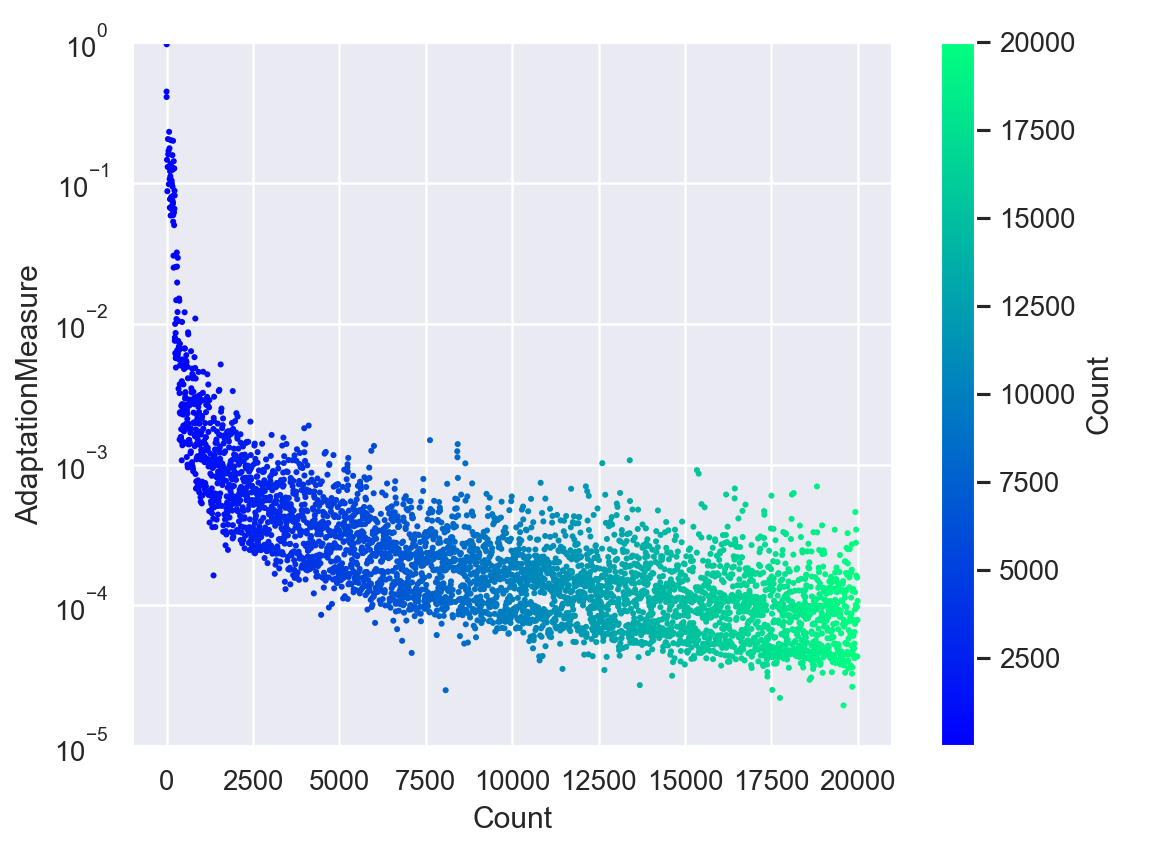

done in 0.174566 seconds.


In [13]:
chain.plot.scatter.scatter.kws.cmap = "winter"
chain.plot.scatter(ycolumns="AdaptationMeasure",ccolumns=[])
chain.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
chain.plot.scatter.currentFig.axes.set_yscale("log")

**The above graph looks quite reassuring.**

## Step 6: Visualize the sampled parameters  

We will now read the resulting sample from the output `*_sample.txt` file.  

In [14]:
pmpd.readSample() # read the final refined sample from the MCMC simulation
sample = pmpd.sampleList[0] 


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/censored*_sample.txt"


ParaDRAM - NOTE: processing sample file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\regression_censored_lognormal_data_paradram\out\censored_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.013962 seconds.
ParaDRAM - NOTE: ndim = 3, count = 1339
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: cr

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


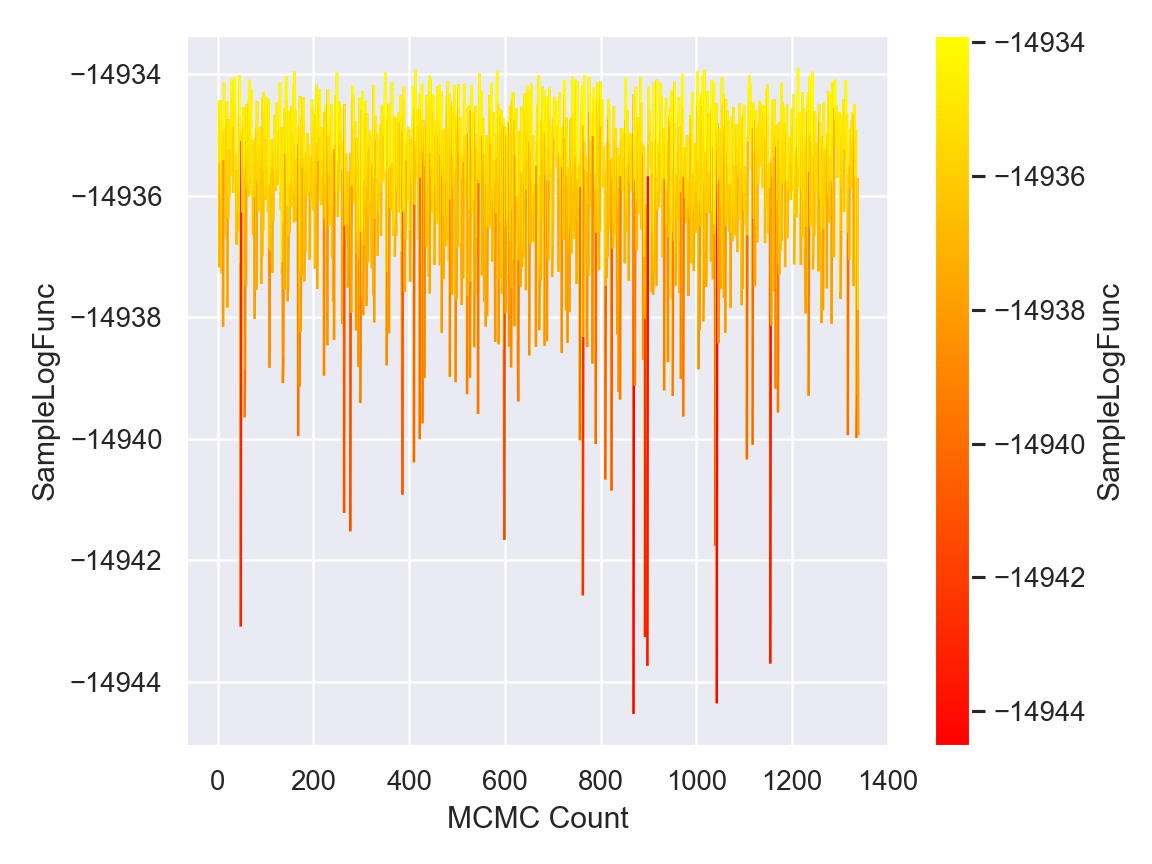

done in 0.174561 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_SampleLogFunc"
ParaDRAM - NOTE: done in 0.176497 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


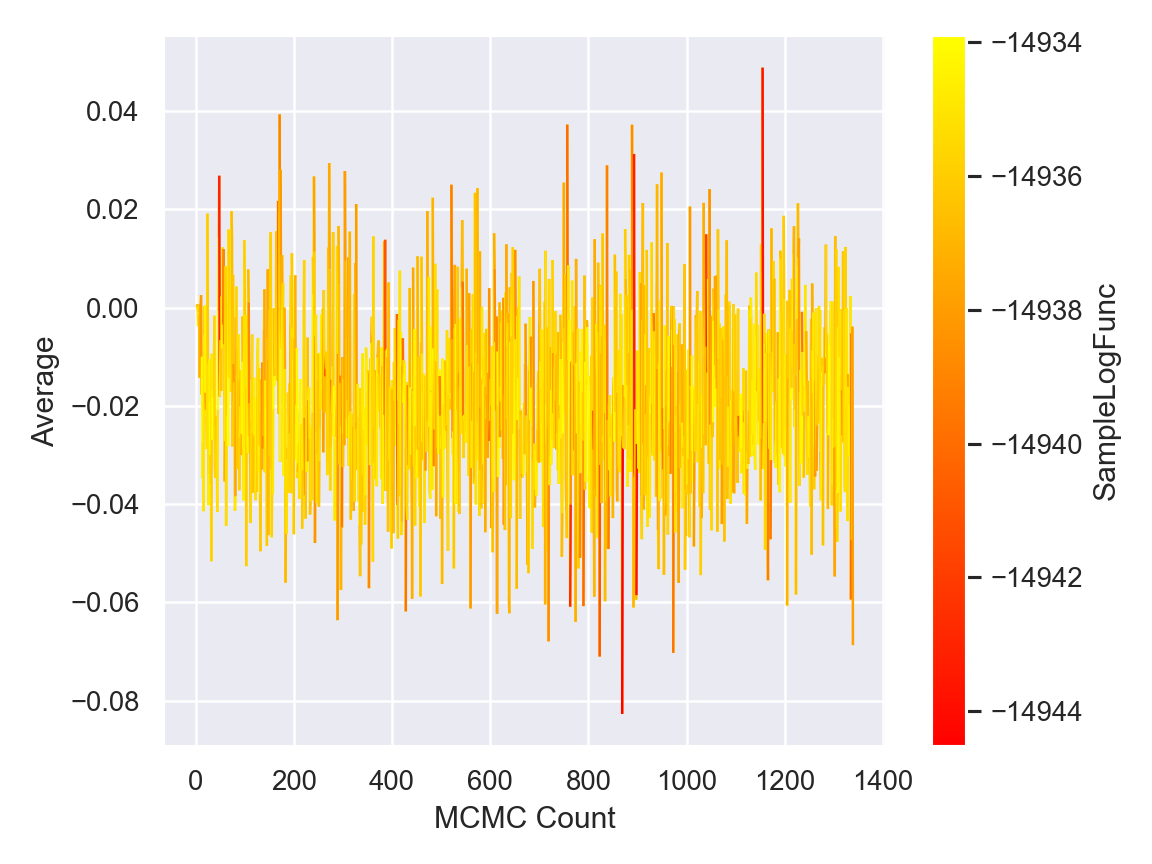

done in 0.183509 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_Average"
ParaDRAM - NOTE: done in 0.121675 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


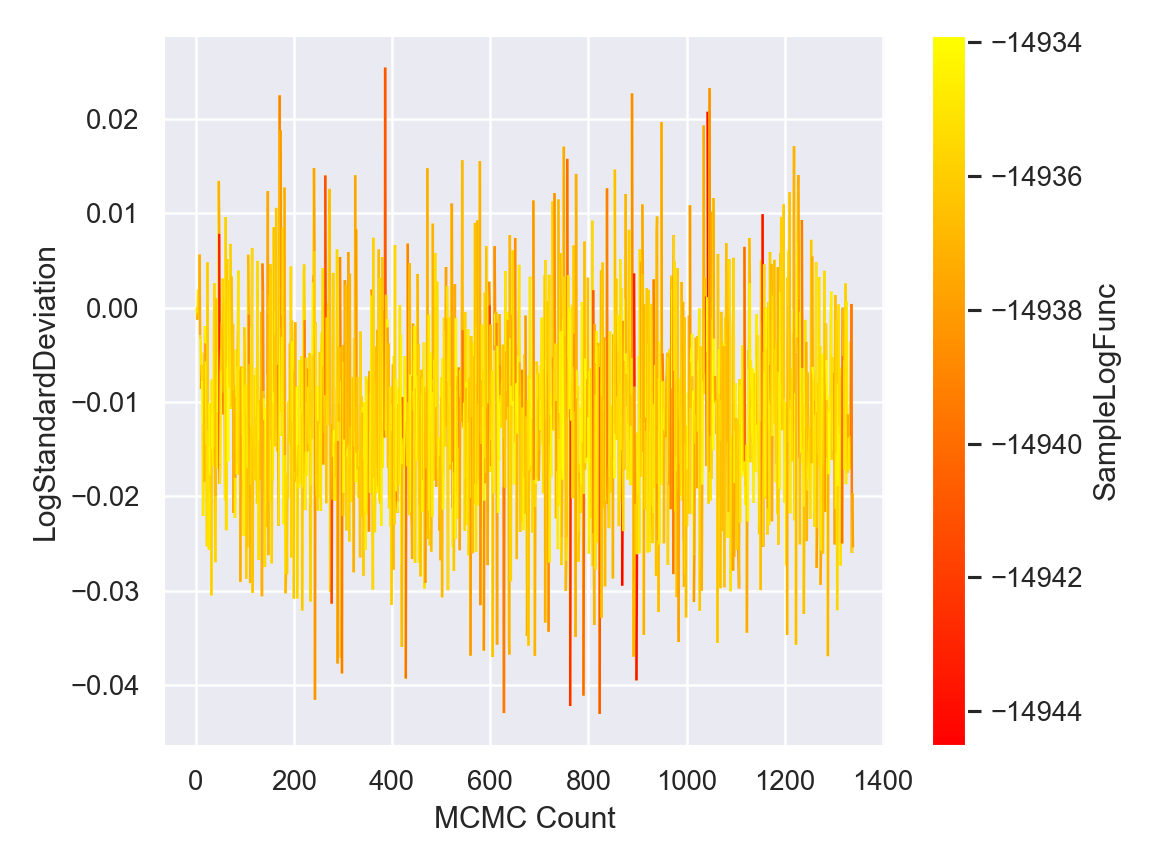

done in 0.128688 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_LogStandardDeviation"
ParaDRAM - NOTE: done in 0.129624 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


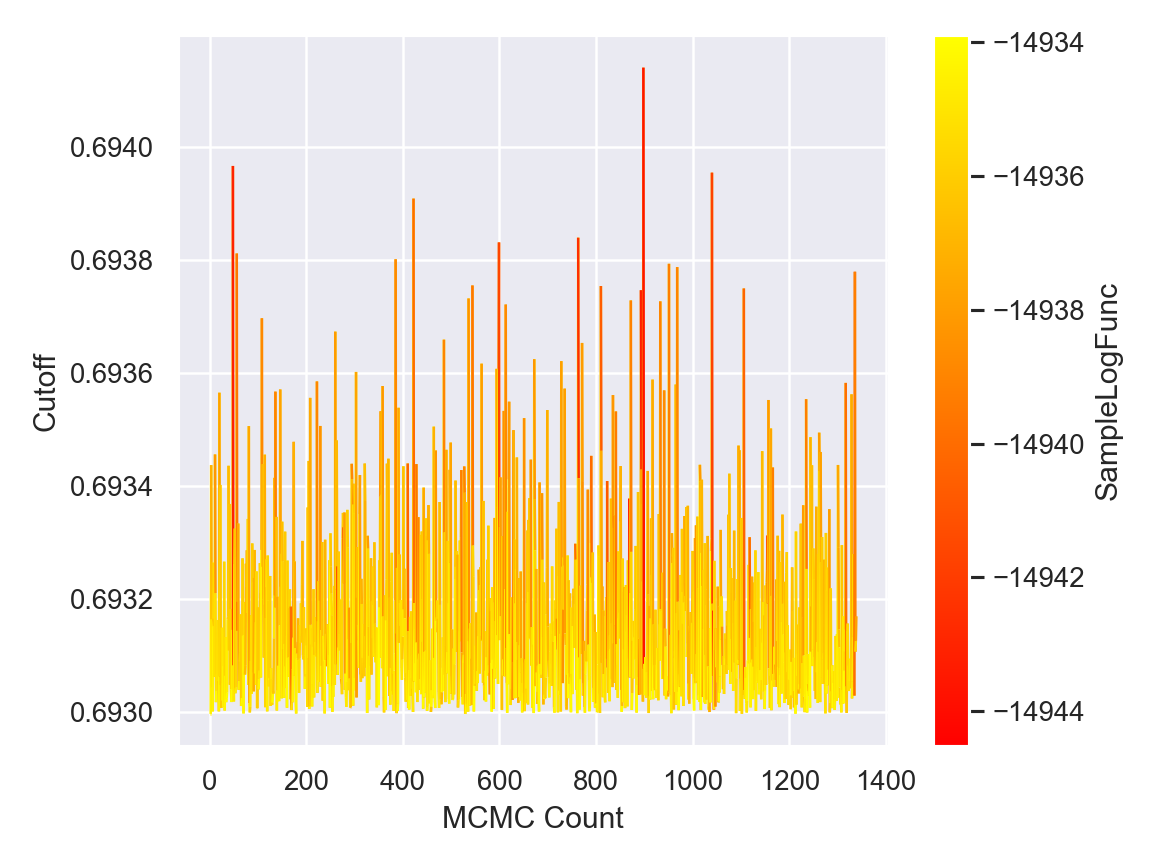

done in 0.131644 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_Cutoff"
ParaDRAM - NOTE: done in 0.120637 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


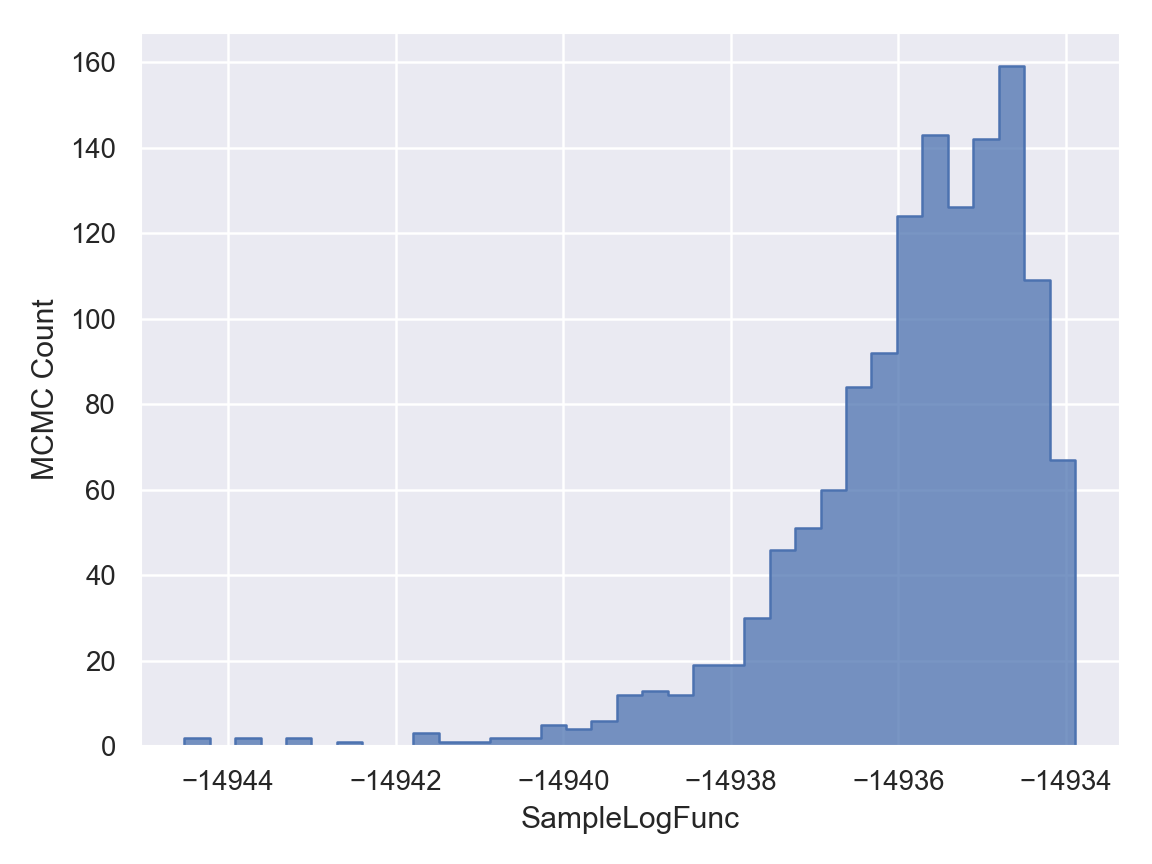

done in 0.095744 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_SampleLogFunc"
ParaDRAM - NOTE: done in 0.109738 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


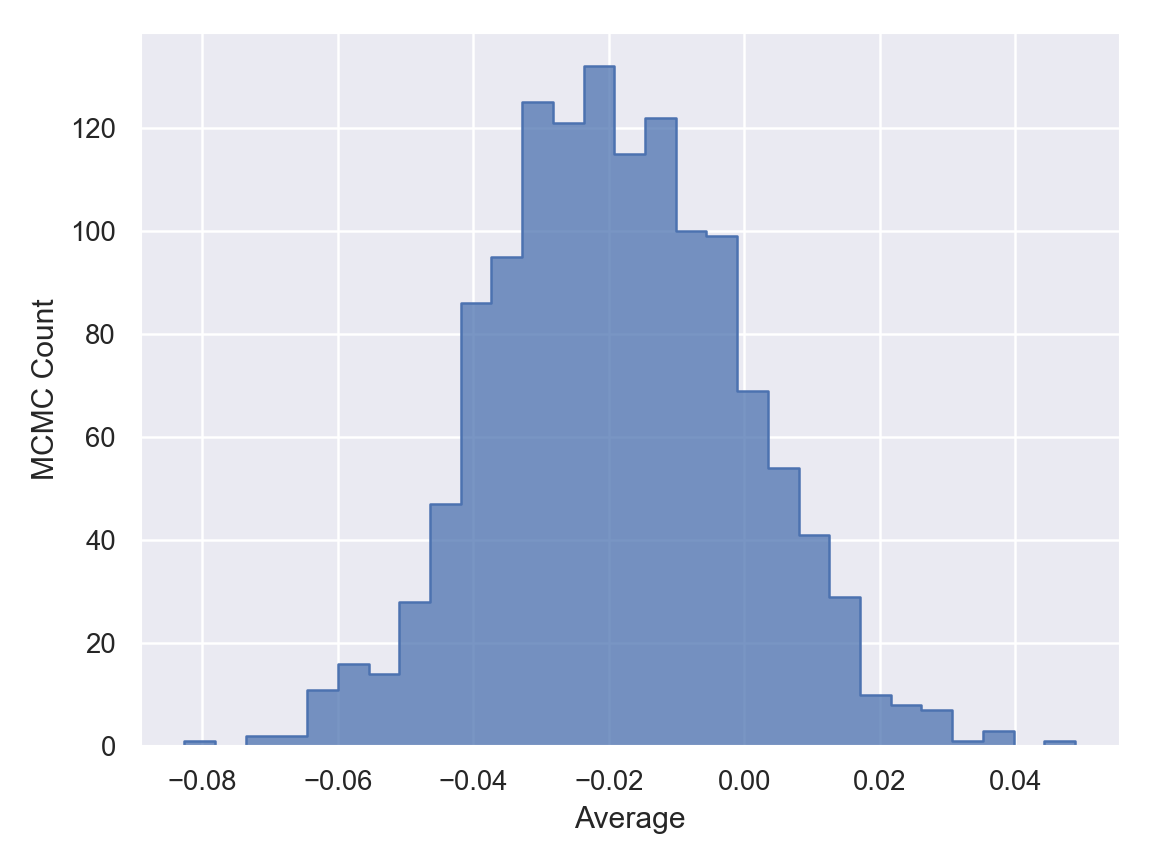

done in 0.092744 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_Average"
ParaDRAM - NOTE: done in 0.067801 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


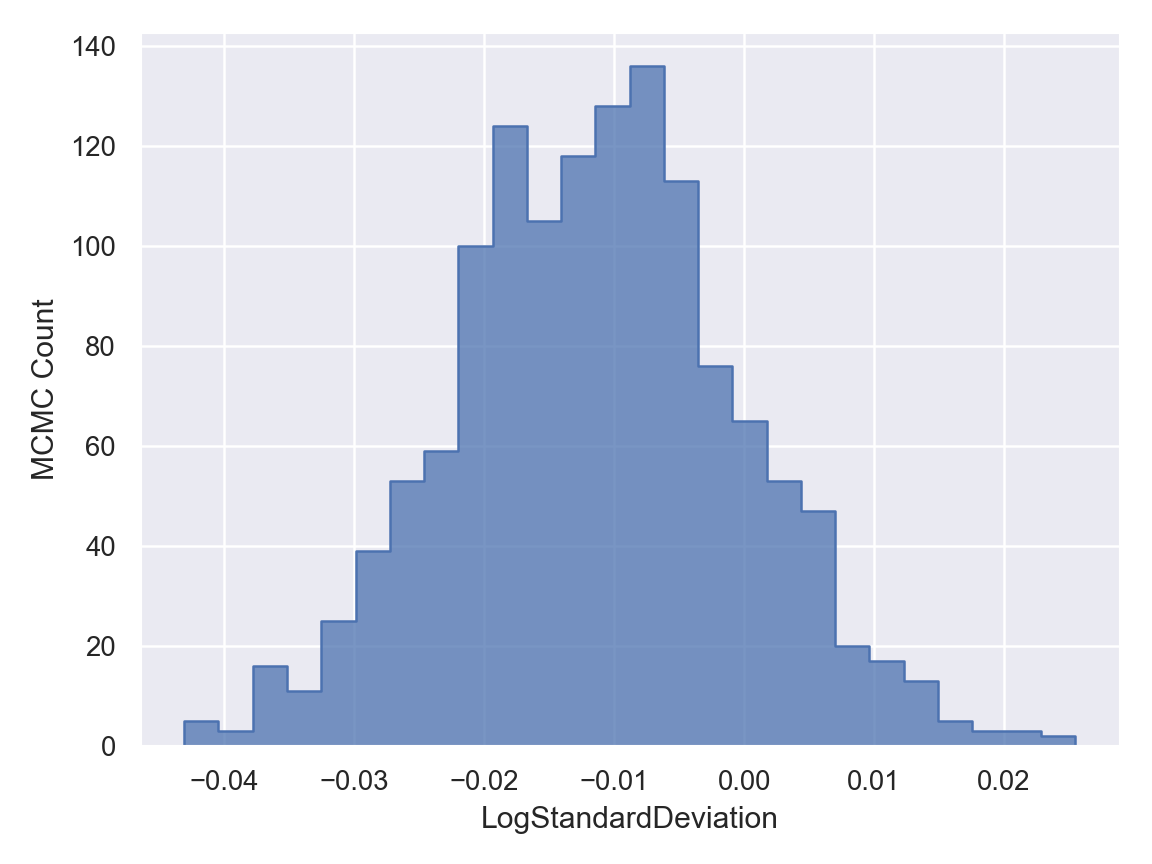

done in 0.096741 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_LogStandardDeviation"
ParaDRAM - NOTE: done in 0.073802 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


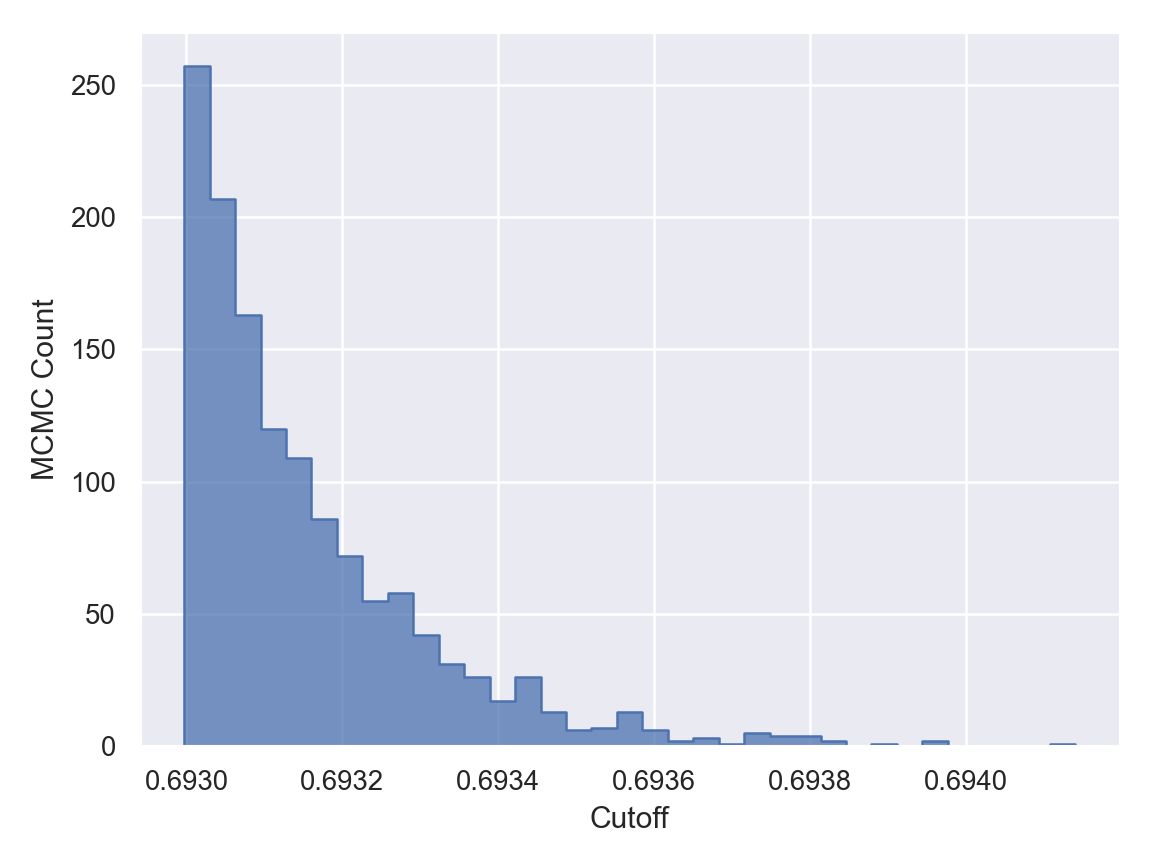

done in 0.095776 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_Cutoff"
ParaDRAM - NOTE: done in 0.073771 seconds.


SampleLogFunc          -14935.831423
Average                    -0.018843
LogStandardDeviation       -0.011297
Cutoff                      0.693156
dtype: float64

In [15]:
# plot the sampled variables

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.line.ycolumns = colname
    sample.plot.line()
    sample.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample.plot.line.currentFig.axes.set_ylabel(colname)
    sample.plot.line.savefig( fname = "./out/traceplot_" + colname )

# plot the histograms of the sampled parameters

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.histplot(xcolumns = colname)
    sample.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
    sample.plot.histplot.savefig( fname = "./out/histogram_" + colname )

# report the average parameters

pmpd.sampleList[0].df.mean()

To visualize the correlation of the parameters with each other, we can make a grid plot of the sample,  

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


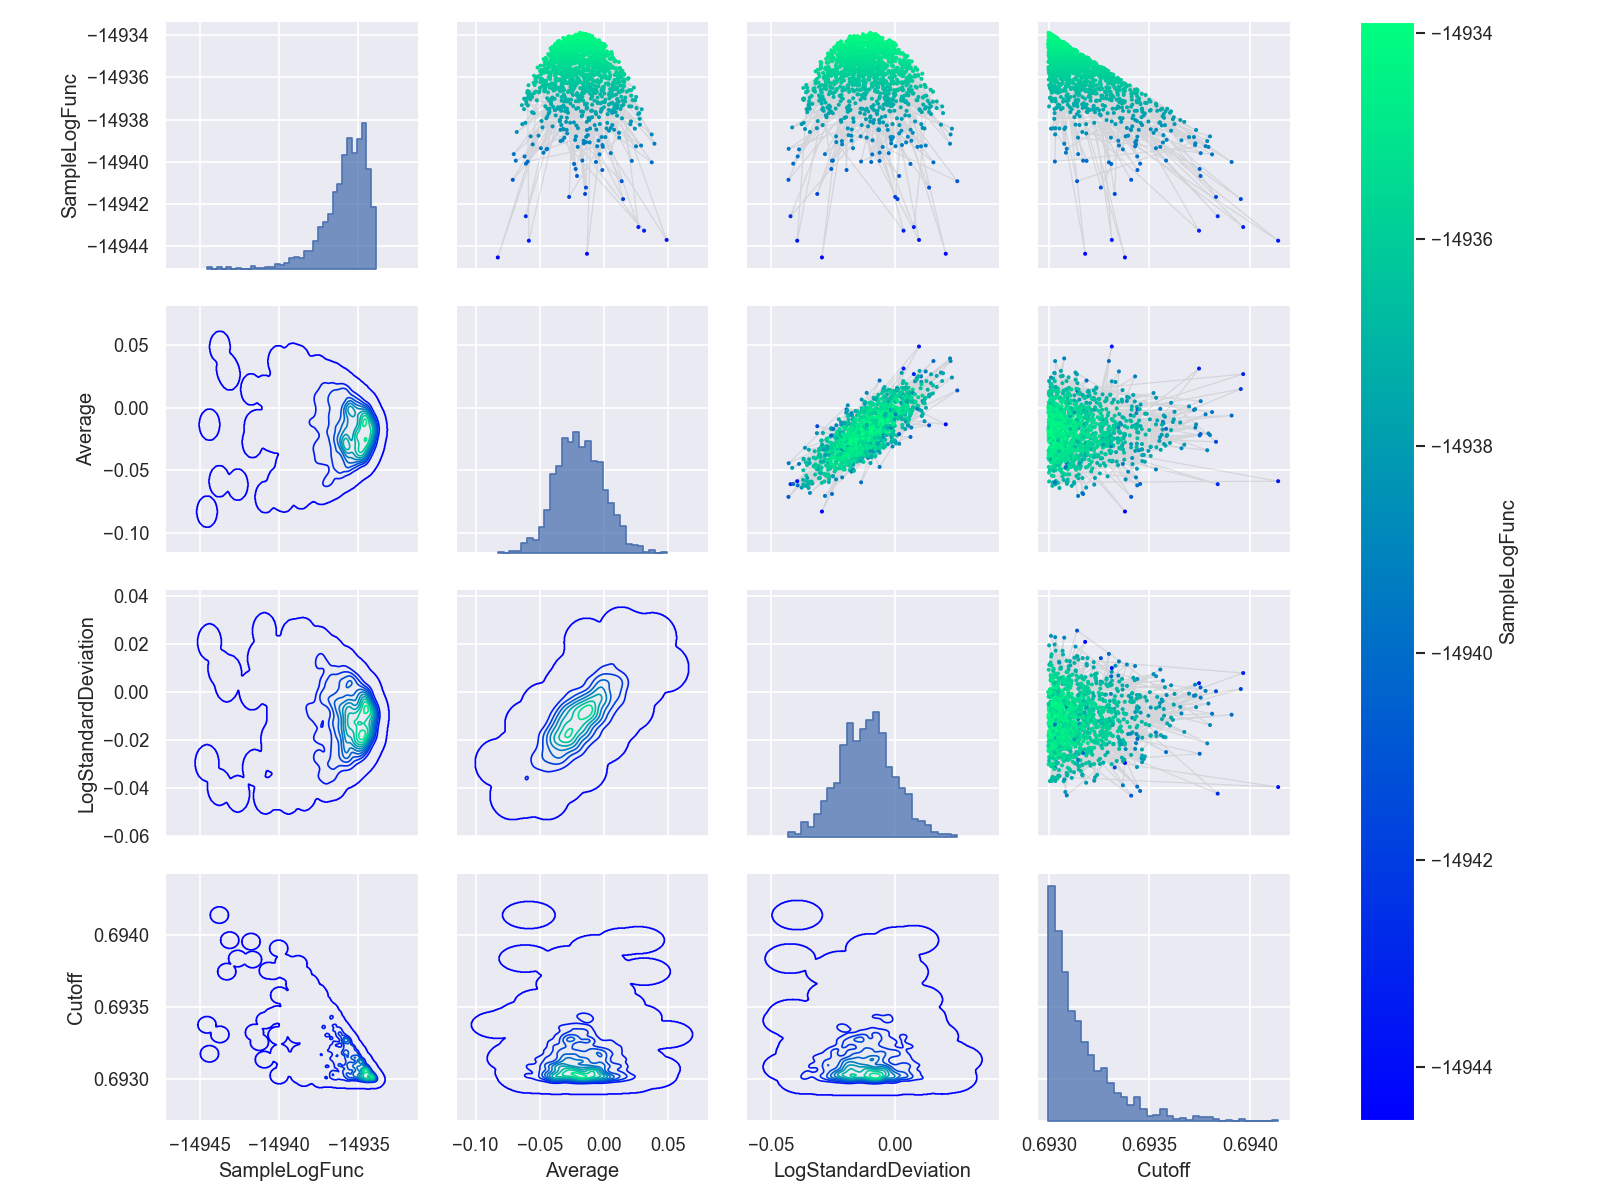

generating subplot #1: (0,0) out of 16... done in 0.051612 seconds.
generating subplot #2: (0,1) out of 16... done in 0.22736 seconds.
generating subplot #3: (0,2) out of 16... done in 0.204486 seconds.
generating subplot #4: (0,3) out of 16... done in 0.201459 seconds.
generating subplot #5: (1,0) out of 16... done in 0.374983 seconds.
generating subplot #6: (1,1) out of 16... done in 0.051612 seconds.
generating subplot #7: (1,2) out of 16... done in 0.204482 seconds.
generating subplot #8: (1,3) out of 16... done in 0.196462 seconds.
generating subplot #9: (2,0) out of 16... done in 0.421838 seconds.
generating subplot #10: (2,1) out of 16... done in 0.403952 seconds.
generating subplot #11: (2,2) out of 16... done in 0.051612 seconds.
generating subplot #12: (2,3) out of 16... done in 0.208409 seconds.
generating subplot #13: (3,0) out of 16... done in 0.453788 seconds.
generating subplot #14: (3,1) out of 16... done in 0.387996 seconds.
generating subplot #15: (3,2) out of 16... d

In [16]:
sample.plot.grid()

### Ensuring independent and identical (i.i.d.) distribution of the final sampled states  

To ensure the iid distribution of the results, we can visualize the autocorrelation of the final refined sample,  

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


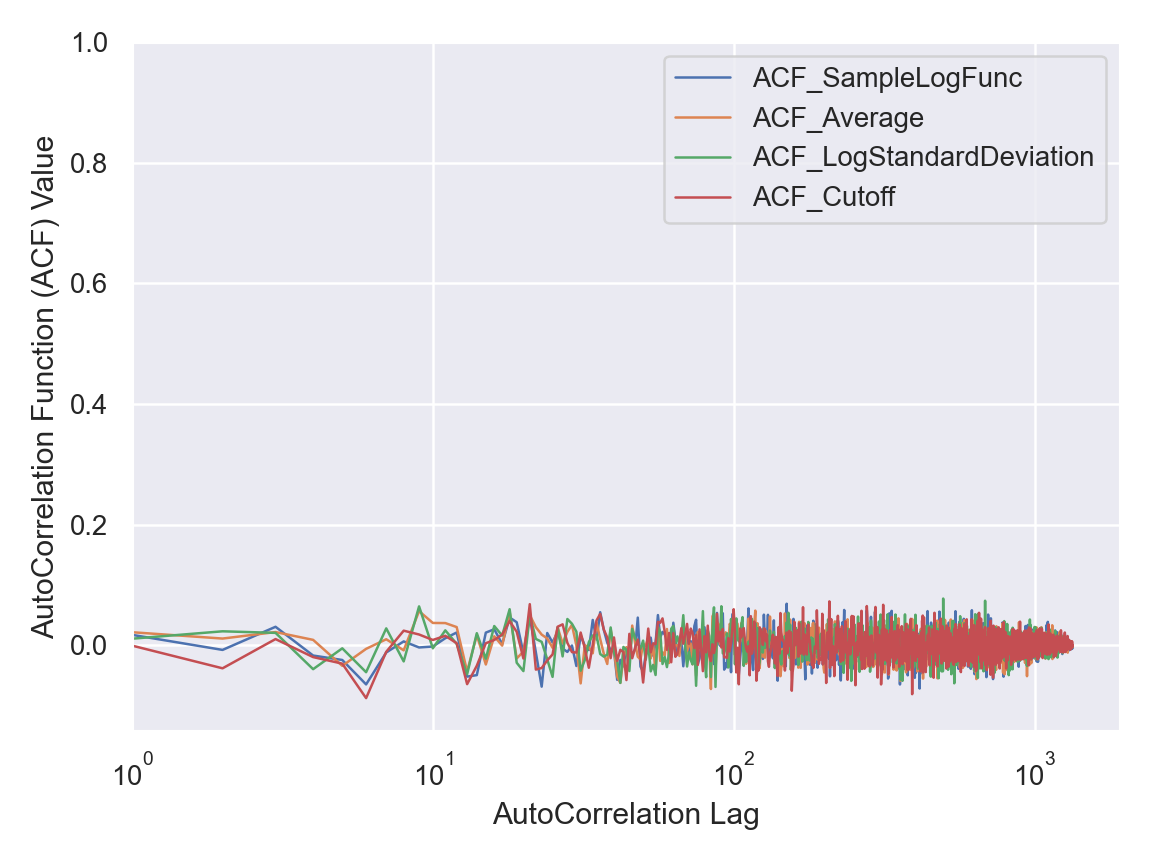

done in 0.251364 seconds.


In [17]:
sample.stats.autocorr.plot.line()

The above plots looks very good and reassuring. Compare it the autocorrelation of the Markov chain,  


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readMarkovchain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/censored*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\Python\Jupyter\regression_censored_lognormal_data_paradram\out\censored_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 2.623014 seconds.
ParaDRAM - NOTE: ndim = 3, count = 80354
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: 

<IPython.core.display.Javascript object>


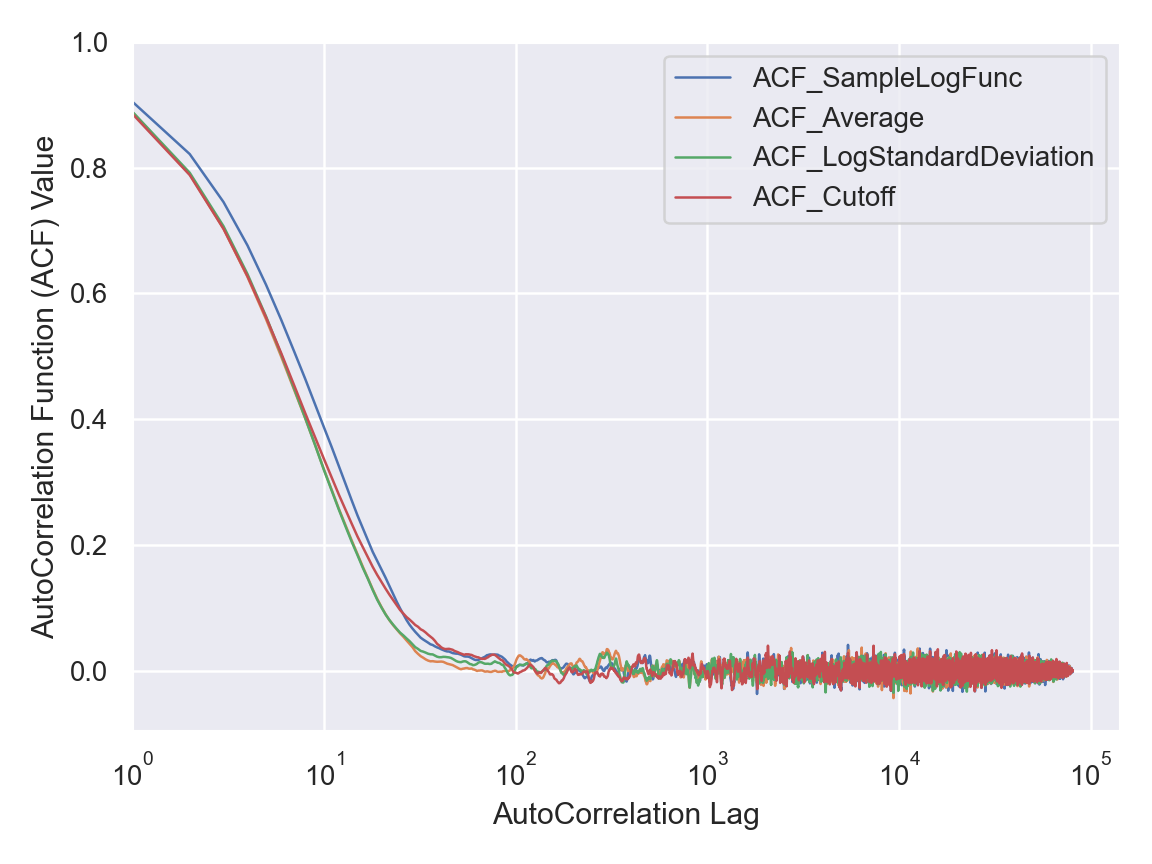

done in 0.453818 seconds.


In [18]:
mchain = pmpd.readMarkovChain(renabled=True)[0] # read the Markov chain
mchain.stats.autocorr.plot.line()

## Step 6: Fit the censored lognormal distribution with the inferred best-fit parameters to the data  
Here is the normal distribution fit to the log-transformation of data,  

<IPython.core.display.Javascript object>


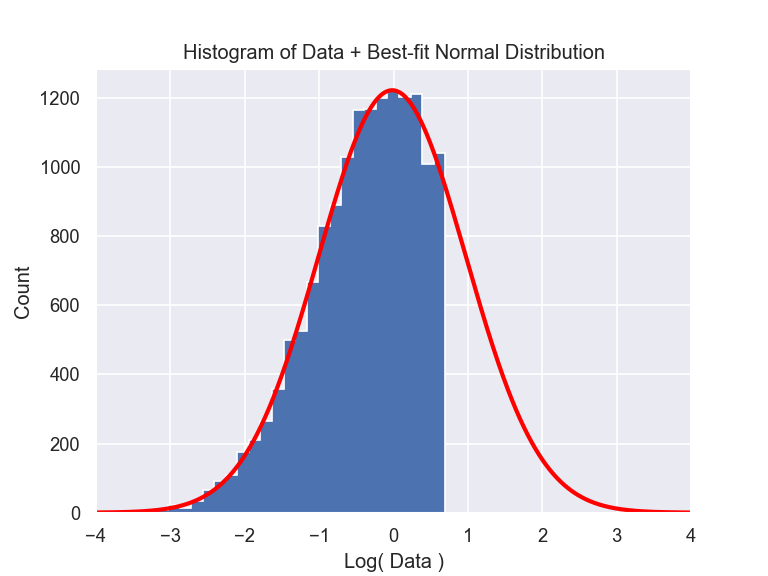

In [19]:
# plot histogram of log(data)

sns.set()
fig = plt.figure()
ax = fig.gca()
(count, bins, patches) = ax.hist(logdata, histtype='stepfilled', bins = 30)
plt.xlabel('Log( Data )')
plt.ylabel('Count')
plt.title('Histogram of Data + Best-fit Normal Distribution')
ax.set_xlim([-4,4])

# plot the best-fit normal distribution

avg = pmpd.sampleList[0].stats.maxLogFunc.state[0] # best-fit mean
std = np.exp(pmpd.sampleList[0].stats.maxLogFunc.state[1]) # best-fit standard deviation

xvalues = np.linspace(-4,4,1000)
yvalues = sp.stats.norm.pdf(x = xvalues, loc = avg, scale = std)
yvalues /= yvalues.max() / count.max() # normalize the PDF to match the distribution of data

ax.plot( xvalues, yvalues, color = "red", linewidth = 2.5 )
plt.show()

How about the original skewed distribution of data?

<IPython.core.display.Javascript object>


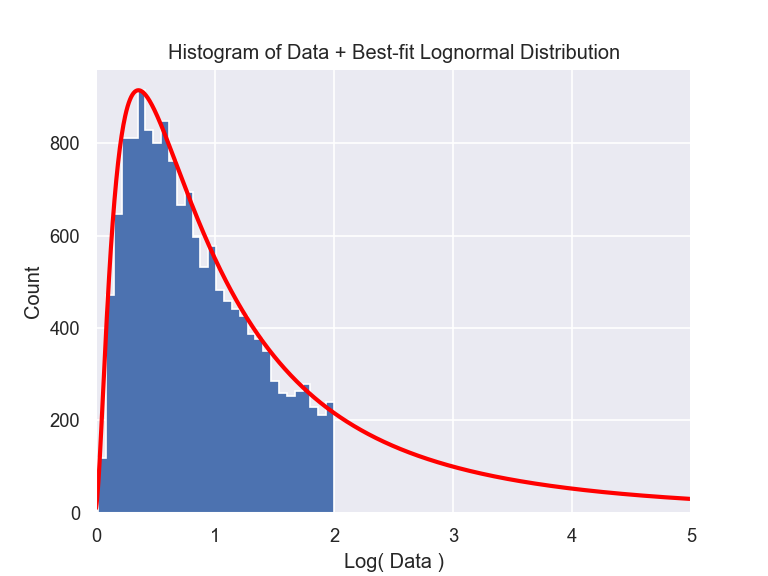

In [20]:
# plot histogram of log(data)

sns.set()
fig = plt.figure()
ax = fig.gca()
(count, bins, patches) = ax.hist(np.exp(logdata), histtype='stepfilled', bins = 30)
plt.xlabel('Log( Data )')
plt.ylabel('Count')
plt.title('Histogram of Data + Best-fit Lognormal Distribution')
ax.set_xlim([0,5])

# plot the best-fit normal distribution

avg = pmpd.sampleList[0].stats.maxLogFunc.state[0] # best-fit mean
std = np.exp(pmpd.sampleList[0].stats.maxLogFunc.state[1]) # best-fit standard deviation

xvalues = np.linspace(0,5,1000)
yvalues = sp.stats.lognorm.pdf(x = xvalues, loc = avg, s = std)
yvalues /= yvalues.max() / count.max() # normalize the PDF to match the distribution of data

ax.plot( xvalues, yvalues, color = "red", linewidth = 2.5 )
plt.show()

>**There are many more functionalities and features of the ParaMonte library that were neither explored nor mentioned in this example Jupyter notebook. You can explore them by checking the existing components of each attribute of the ParaDRAM sampler class and by visiting the [ParaMonte library's documentation website](http://cdslab.org/paramonte/)**.